## Bài tập cuối kì
## Xử lý ảnh (12/2025)
Trong bài tập này, ta sẽ xem xét tập ảnh (gọi là tập ảnh A) được lưu ở link: https://dutudn-my.sharepoint.com/my?id=%2Fpersonal%2Fhptien%5Fdut%5Fudn%5Fvn%2FDocuments%2FMyTeaching%2FCourse%2FDTVT%5FXLA%2FDataset%2FPet%2Fimages&ga=1. 

Đây là tập ảnh con được trích ra từ bộ dữ liệu “Oxford-IIIT Pet Dataset”  mà đã sử dụng ở lớp.
1. Kiểm tra các ảnh trong tập A và ground truth (mask) tương ứng (ground truth này nằm trong thư mục annotations của tập dữ liệu “Oxford-IIIT Pet Dataset” mà đã dùng ở lớp). Viết code để đếm số lượng ảnh trong A mà tồn tại ground truth tương ứng. Sau đây, ta gọi B là tập chứa các ảnh trong A có tồn tại ground truth tương ứng.

2. Hiệu chỉnh ground truth của các ảnh trong B như sau. Với mỗi ground truth, giữ lại miền nằm trong cùng của đối tượng, miền này có giá trị ground truth ban đầu là 1. Các miền còn lại nhận giá trị là 0. Như vậy, ground truth sau hiệu chỉnh sẽ là một ảnh nhị phân (nền có giá trị 0, đối tượng có giá trị 1). Minh họa một vài ảnh, ground truth gốc, ground truth sau hiệu chỉnh.

3. Với từng ground truth mới thu được, ta tiếp tục hiệu chỉnh bằng cách dùng phép Dilation với phần tử cấu trúc có dạng “disk” và bán kính bằng 9. Minh họa kết quả. Cho biết ý nghĩa của bước này.

4. Dùng phương pháp lấy ngưỡng Otsu để phân vùng các ảnh trong tập B (phân thành 2 vùng: đối tượng và nền). Minh họa kết quả với một vài hình trong B. Nhận xét.

5. Làm lại câu 4 với phương pháp K-means.

6. Viết code để thực hiện các tiêu chí đánh giá IoU (hay Jaccard) và Dice.

7. Áp dụng hai tiêu chí này để đánh giá kết quả của câu 4 và 5, áp dụng cho tất cả các ảnh trong tập B và lấy giá trị trung bình.

8. So sánh kết quả từ hàm IoU và Dice tự viết ở câu 6 với hàm IoU và Dice có sẵn (ví dụ Matlab).

9. Đề xuất một phương pháp phân vùng khác (không cần quá phức tạp) để cải thiện kết quả phân vùng. Minh họa kết quả.    


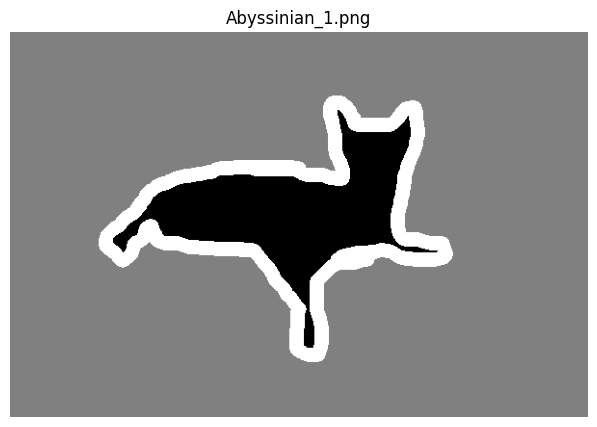

In [32]:
import cv2
import matplotlib.pyplot as plt

p = r"C:\Users\LENOVO\Desktop\IP_cuoiki\annotations\trimaps\Abyssinian_1.png"

img = cv2.imread(p, cv2.IMREAD_UNCHANGED)  # đọc cả ảnh xám/alpha nếu có
if img is None:
    print("Không đọc được (file ._ thường không phải ảnh PNG thật).")
else:
    # nếu ảnh có 3 kênh thì chuyển sang RGB để hiển thị đúng màu
    if len(img.shape) == 3 and img.shape[2] >= 3:
        img_show = cv2.cvtColor(img[:, :, :3], cv2.COLOR_BGR2RGB)
    else:
        img_show = img

    plt.imshow(img_show, cmap="gray")
    plt.axis("off")
    plt.title(p.split("\\")[-1])
    plt.show()


In [1]:
# CELL 1: Import thư viện và khai báo đường dẫn
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.metrics import jaccard_score
from skimage.morphology import disk, binary_dilation
from skimage.filters import threshold_otsu
from skimage.color import rgb2gray
import warnings
warnings.filterwarnings('ignore')

# Thiết lập hiển thị tiếng Việt cho matplotlib
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (15, 5)

# Đường dẫn thư mục làm việc
BASE_DIR = Path('C:/Users/LENOVO/Desktop/IP_cuoiki')
IMAGES_DIR = BASE_DIR / 'images'
TRIMAPS_DIR = BASE_DIR / 'annotations' / 'trimaps'
XMLS_DIR = BASE_DIR / 'annotations' / 'xmls'

print("Đường dẫn thư mục làm việc:", BASE_DIR.absolute())
print("Thư mục ảnh:", IMAGES_DIR)
print("Thư mục trimaps:", TRIMAPS_DIR)


Đường dẫn thư mục làm việc: C:\Users\LENOVO\Desktop\IP_cuoiki
Thư mục ảnh: C:\Users\LENOVO\Desktop\IP_cuoiki\images
Thư mục trimaps: C:\Users\LENOVO\Desktop\IP_cuoiki\annotations\trimaps


In [3]:
# CELL 2: Tạo tập B - Lọc ảnh có ground truth tương ứng
def create_dataset_B():
    # Lấy danh sách tất cả ảnh trong thư mục images/
    image_files = sorted([f for f in os.listdir(IMAGES_DIR) 
                         if f.endswith('.jpg') and not f.startswith('._')])
    
    dataset_A = []  # Tập A: tất cả ảnh
    dataset_B = []  # Tập B: ảnh có ground truth
    
    for img_file in image_files:
        img_path = IMAGES_DIR / img_file
        dataset_A.append(img_path)
        
        # Tìm trimap tương ứng (đổi .jpg → .png)
        trimap_file = img_file.replace('.jpg', '.png')
        trimap_path = TRIMAPS_DIR / trimap_file
        
        # Kiểm tra trimap có tồn tại và không phải file ẩn
        if trimap_path.exists() and not trimap_file.startswith('._'):
            dataset_B.append((str(img_path), str(trimap_path)))
    
    return dataset_A, dataset_B

# Tạo tập A và B
dataset_A, dataset_B = create_dataset_B()

print(f"Số lượng ảnh trong tập A (toàn bộ): {len(dataset_A)}")
print(f"Số lượng ảnh trong tập B (có ground truth): {len(dataset_B)}")
print(f"\n{'='*60}")
# Hiển thị 5 mẫu đầu tiên của tập B
print("Danh sách 5 mẫu đầu tiên trong tập B:")
for i, (img_path, mask_path) in enumerate(dataset_B[:5], 1):
    print(f"{i}. Ảnh: {Path(img_path).name} | Mask: {Path(mask_path).name}")


Số lượng ảnh trong tập A (toàn bộ): 58
Số lượng ảnh trong tập B (có ground truth): 58

Danh sách 5 mẫu đầu tiên trong tập B:
1. Ảnh: Abyssinian_1.jpg | Mask: Abyssinian_1.png
2. Ảnh: Abyssinian_10.jpg | Mask: Abyssinian_10.png
3. Ảnh: Abyssinian_12.jpg | Mask: Abyssinian_12.png
4. Ảnh: Abyssinian_17.jpg | Mask: Abyssinian_17.png
5. Ảnh: Abyssinian_18.jpg | Mask: Abyssinian_18.png


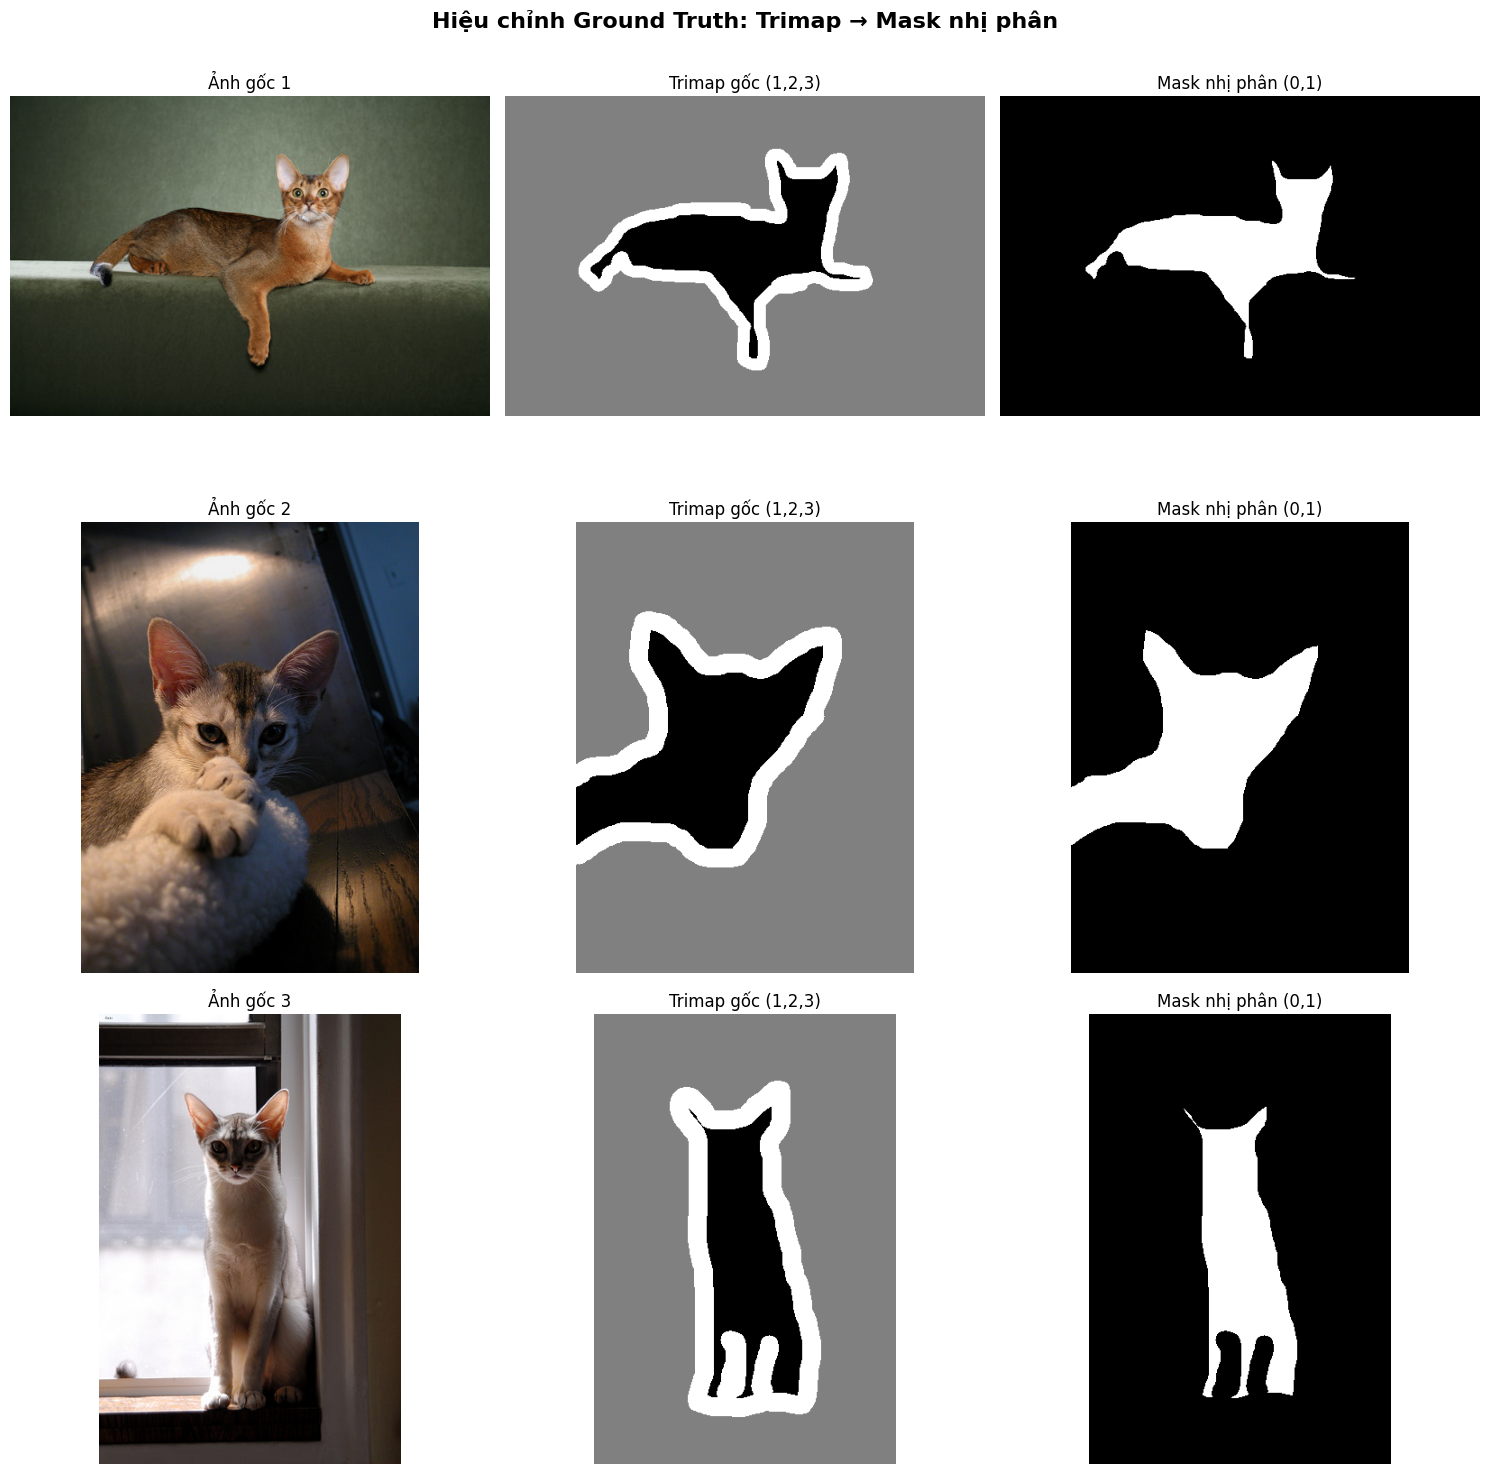

In [4]:
# CELL 3: Hiệu chỉnh ground truth (trimap → mask nhị phân)
def fix_trimap_to_binary(trimap): 
    # 1 (đối tượng)  → 1
    # 2 (biên)       → 0
    # 3 (nền)        → 0

    # Tạo mask nhị phân: giữ lại chỉ pixel có giá trị = 1
    mask_binary = (trimap == 1).astype(np.uint8)
    return mask_binary

# Minh họa hiệu chỉnh ground truth với 3 ảnh mẫu
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Hiệu chỉnh Ground Truth: Trimap → Mask nhị phân', 
             fontsize=16, fontweight='bold')

for idx in range(3):
    img_path, trimap_path = dataset_B[idx]
    
    # Đọc ảnh gốc và trimap
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    trimap = cv2.imread(trimap_path, cv2.IMREAD_GRAYSCALE)
    
    # Hiệu chỉnh trimap thành mask nhị phân
    mask_binary = fix_trimap_to_binary(trimap)
    
    # Hiển thị
    axes[idx, 0].imshow(img_rgb)
    axes[idx, 0].set_title(f'Ảnh gốc {idx+1}')
    axes[idx, 0].axis('off')
    
    axes[idx, 1].imshow(trimap, cmap='gray')
    axes[idx, 1].set_title(f'Trimap gốc (1,2,3)')
    axes[idx, 1].axis('off')
    
    axes[idx, 2].imshow(mask_binary, cmap='gray')
    axes[idx, 2].set_title(f'Mask nhị phân (0,1)')
    axes[idx, 2].axis('off')

plt.tight_layout()
plt.show()

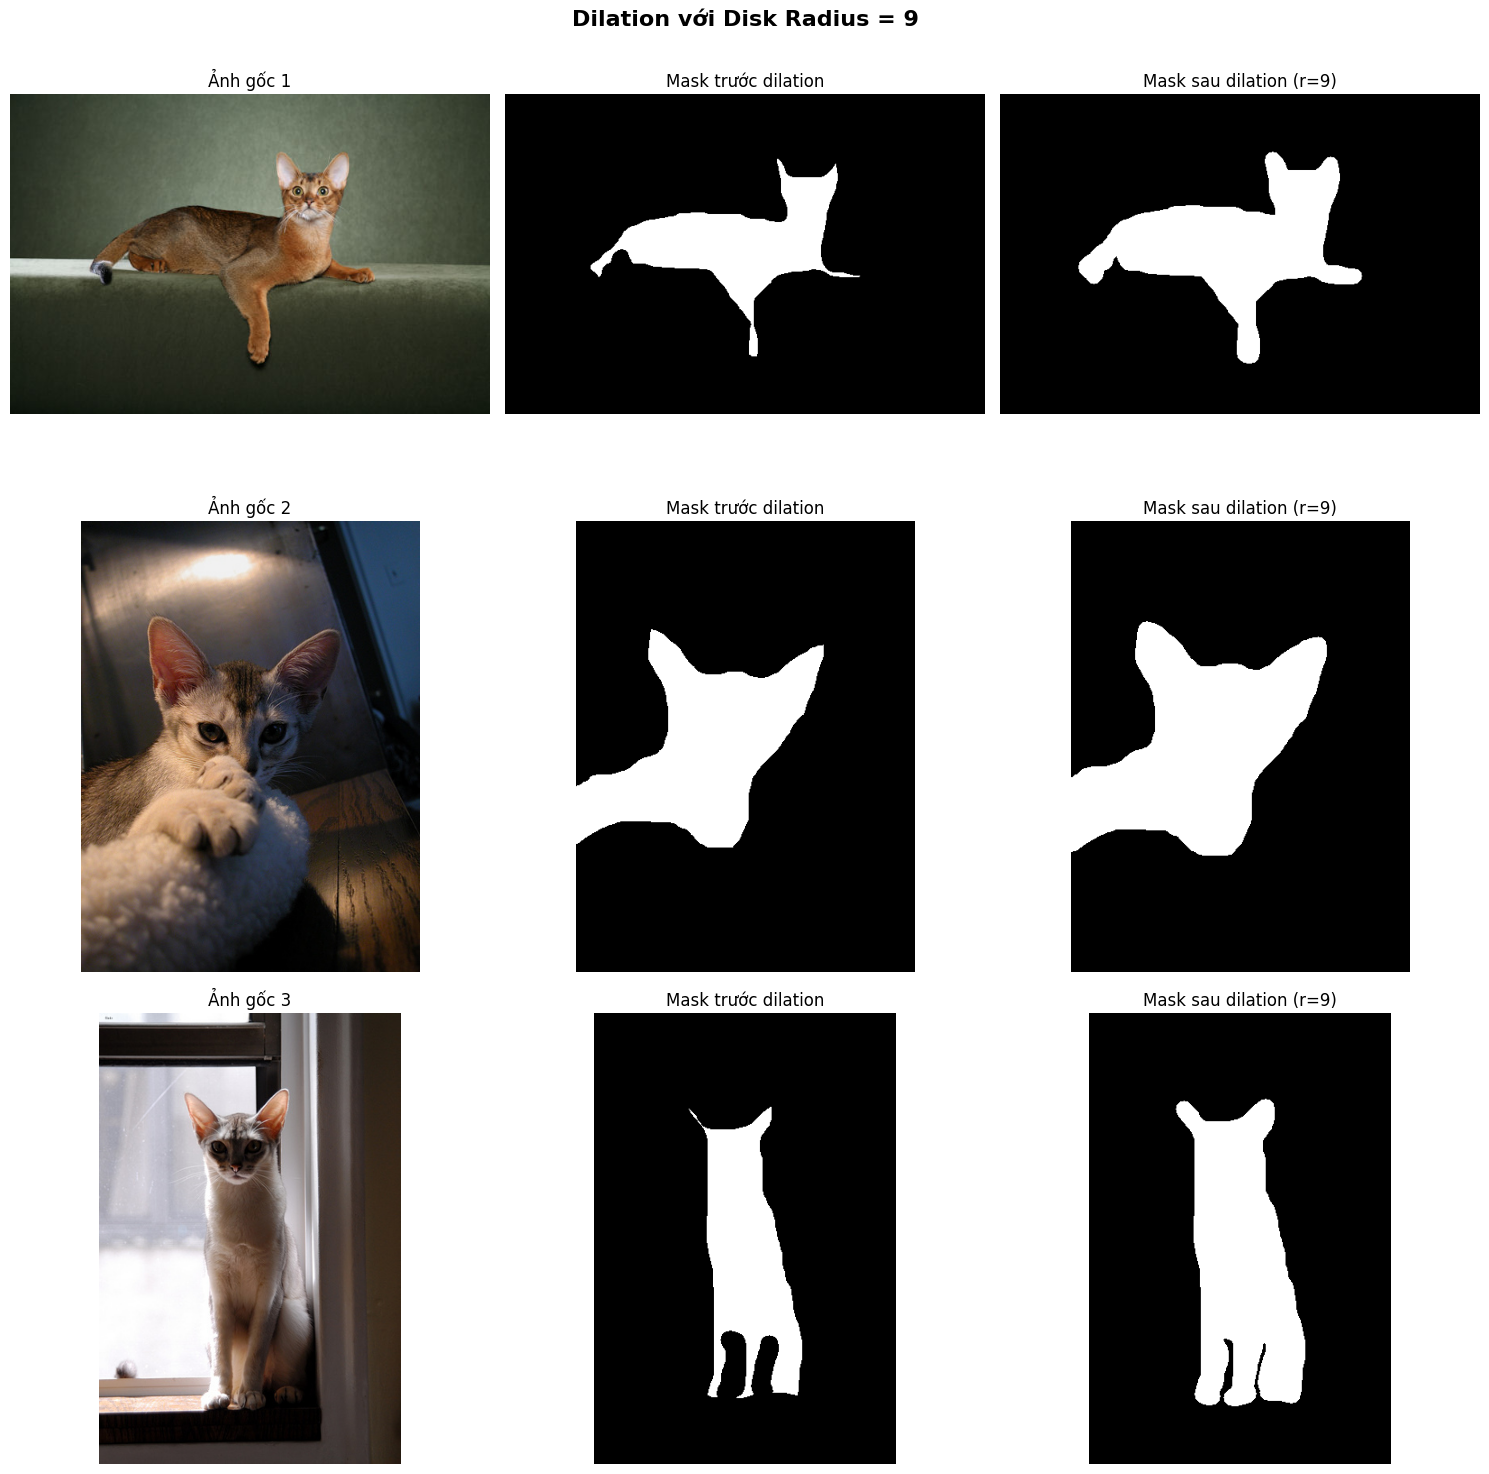


 Tại sao cần Dilation?
- Phép giãn nở làm 'dày' thêm vùng đối tượng trong ground truth
- Bù đắp cho sai số ở biên khi phân vùng tự động
- Tăng khả năng 'tolerant' với các thuật toán segmentation đơn giản
- Tránh trường hợp thuật toán dự đoán sát biên nhưng bị đánh giá thấp
- Với radius=9, ta mở rộng biên khoảng 9 pixel về mọi hướng



In [5]:
# CELL 4: Dilation với phần tử cấu trúc disk radius = 9
def dilate_mask(mask_binary, radius=9):

    # Tạo phần tử cấu trúc hình đĩa (disk)
    selem = disk(radius)
    
    # Áp dụng dilation
    mask_dilated = binary_dilation(mask_binary, selem).astype(np.uint8)
    
    return mask_dilated

# Minh họa dilation với 3 ảnh mẫu
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Dilation với Disk Radius = 9', fontsize=16, fontweight='bold')

for idx in range(3):
    img_path, trimap_path = dataset_B[idx]
    
    # Đọc ảnh gốc và trimap
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    trimap = cv2.imread(trimap_path, cv2.IMREAD_GRAYSCALE)
    
    # Tạo mask nhị phân
    mask_binary = fix_trimap_to_binary(trimap)
    
    # Áp dụng dilation
    mask_dilated = dilate_mask(mask_binary, radius=9)
    
    # Hiển thị
    axes[idx, 0].imshow(img_rgb)
    axes[idx, 0].set_title(f'Ảnh gốc {idx+1}')
    axes[idx, 0].axis('off')
    
    axes[idx, 1].imshow(mask_binary, cmap='gray')
    axes[idx, 1].set_title(f'Mask trước dilation')
    axes[idx, 1].axis('off')
    
    axes[idx, 2].imshow(mask_dilated, cmap='gray')
    axes[idx, 2].set_title(f'Mask sau dilation (r=9)')
    axes[idx, 2].axis('off')

plt.tight_layout()
plt.show()

print("\n Tại sao cần Dilation?")
print("- Phép giãn nở làm 'dày' thêm vùng đối tượng trong ground truth")
print("- Bù đắp cho sai số ở biên khi phân vùng tự động")
print("- Tăng khả năng 'tolerant' với các thuật toán segmentation đơn giản")
print("- Tránh trường hợp thuật toán dự đoán sát biên nhưng bị đánh giá thấp")
print("- Với radius=9, ta mở rộng biên khoảng 9 pixel về mọi hướng\n")


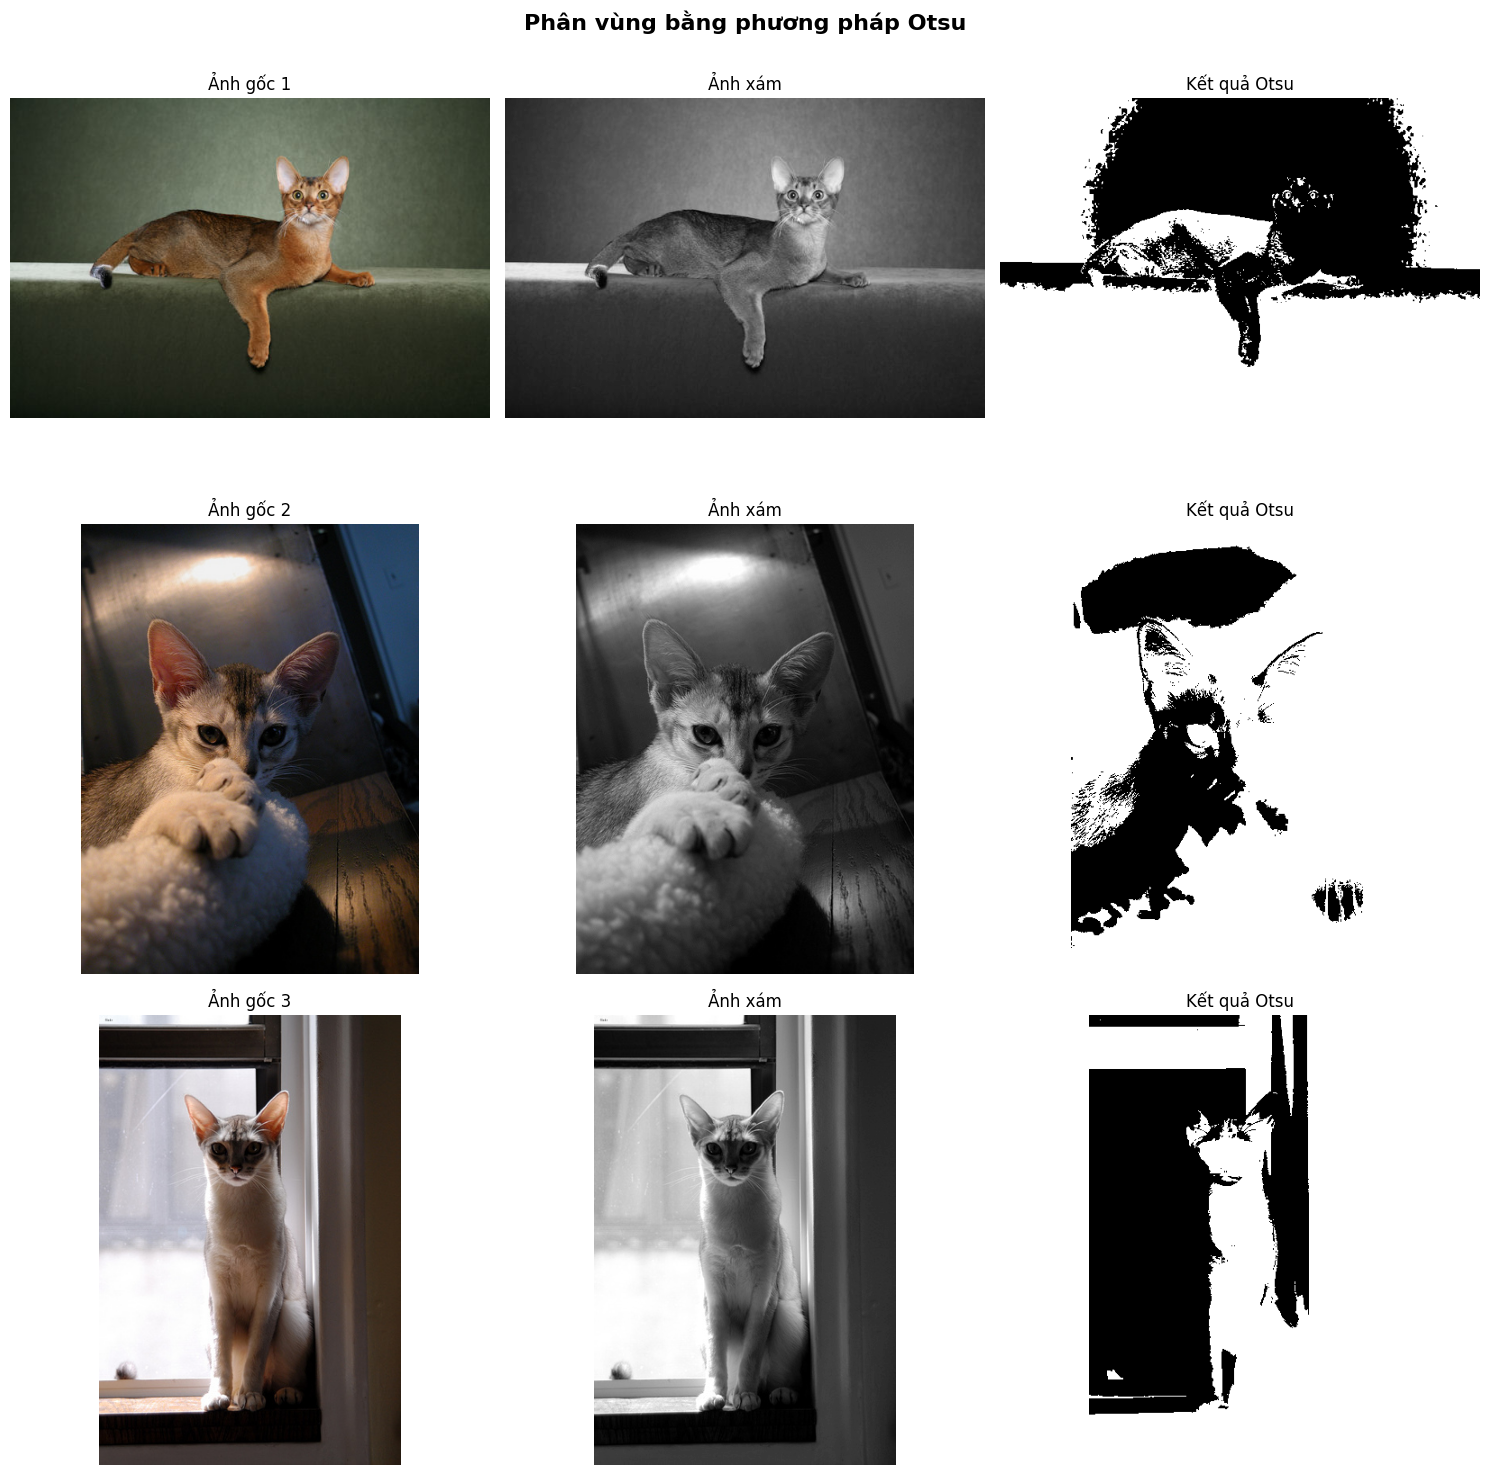


 Nhận xét về phương pháp Otsu:
- Otsu tự động tìm ngưỡng tối ưu để tách 2 lớp (foreground/background)
- Hoạt động tốt khi histogram có 2 đỉnh rõ ràng
- Đơn giản, nhanh, không cần tham số
- Hạn chế: nhạy cảm với ánh sáng không đồng đều, nhiễu



In [6]:
# CELL 5: Phân vùng bằng Otsu
def segment_otsu(gray_image):
    # Tính ngưỡng Otsu
    thresh = threshold_otsu(gray_image)
    
    # Tạo mask nhị phân (đối tượng thường tối hơn nền)
    # Nếu pixel < threshold → đối tượng (1), ngược lại → nền (0)
    mask = (gray_image < thresh).astype(np.uint8)
    
    return mask

# Minh họa phân vùng Otsu với 3 ảnh mẫu
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Phân vùng bằng phương pháp Otsu', fontsize=16, fontweight='bold')

for idx in range(3):
    img_path, _ = dataset_B[idx]
    
    # Đọc ảnh
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Phân vùng Otsu
    mask_otsu = segment_otsu(gray)
    
    # Hiển thị
    axes[idx, 0].imshow(img_rgb)
    axes[idx, 0].set_title(f'Ảnh gốc {idx+1}')
    axes[idx, 0].axis('off')
    
    axes[idx, 1].imshow(gray, cmap='gray')
    axes[idx, 1].set_title(f'Ảnh xám')
    axes[idx, 1].axis('off')
    
    axes[idx, 2].imshow(mask_otsu, cmap='gray')
    axes[idx, 2].set_title(f'Kết quả Otsu')
    axes[idx, 2].axis('off')

plt.tight_layout()
plt.show()

print("\n Nhận xét về phương pháp Otsu:")
print("- Otsu tự động tìm ngưỡng tối ưu để tách 2 lớp (foreground/background)")
print("- Hoạt động tốt khi histogram có 2 đỉnh rõ ràng")
print("- Đơn giản, nhanh, không cần tham số")
print("- Hạn chế: nhạy cảm với ánh sáng không đồng đều, nhiễu\n")


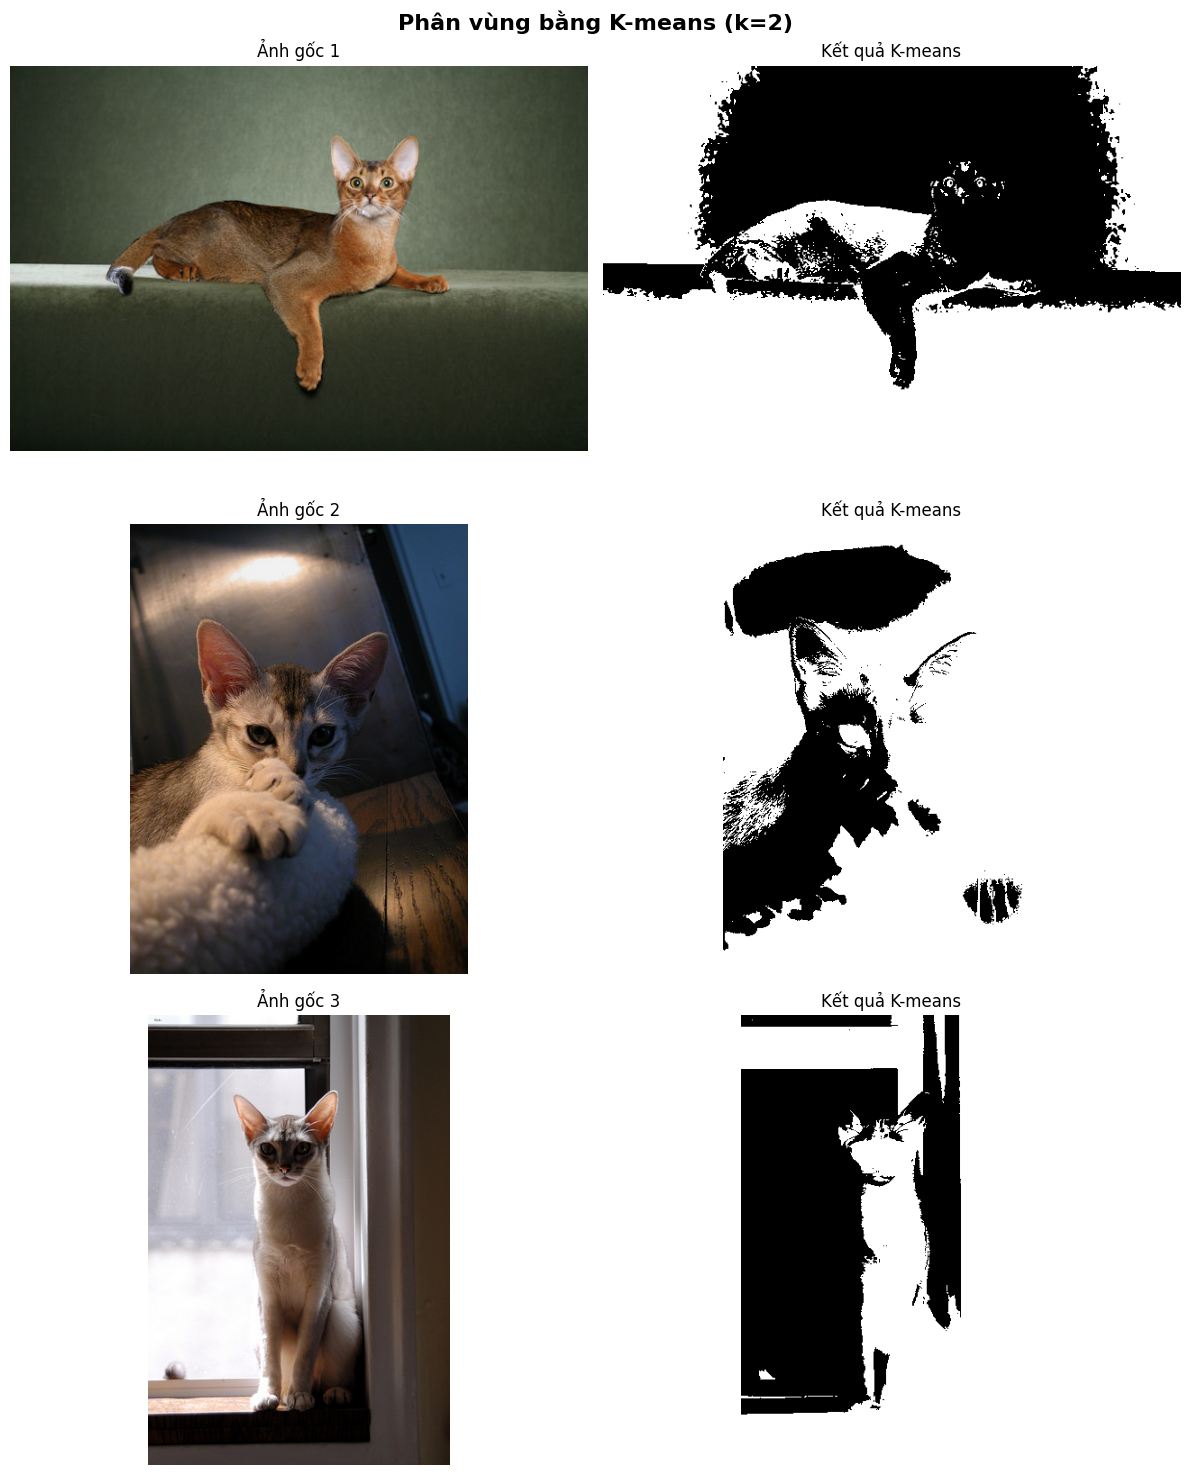


 Nhận xét về phương pháp K-means:
- K-means phân cụm pixel dựa trên đặc trưng màu sắc
- Sử dụng không gian Lab tốt hơn RGB (tách biệt độ sáng và màu)
- Có thể xử lý tốt hơn Otsu khi đối tượng có màu sắc đặc trưng
- Hạn chế: cần xác định số cụm, nhạy cảm với khởi tạo



In [8]:
# CELL 6: Phân vùng bằng K-means
def segment_kmeans(image, n_clusters=2):
    
    # Chuyển sang không gian Lab (tốt hơn RGB cho clustering)
    img_lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    
    # Reshape thành mảng 2D (n_pixels, 3_channels)
    h, w = img_lab.shape[:2]
    pixels = img_lab.reshape(-1, 3)
    
    # Áp dụng K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(pixels)
    
    # Reshape lại thành ảnh
    labels = labels.reshape(h, w)
    
    # Chọn cụm tương ứng với đối tượng
    # Giả sử đối tượng (pet) có độ sáng trung bình thấp hơn nền
    # Tính độ sáng trung bình của mỗi cụm
    cluster_means = []
    for i in range(n_clusters):
        cluster_pixels = pixels[labels.reshape(-1) == i]
        cluster_means.append(cluster_pixels[:, 0].mean())  # Kênh L
    
    # Cụm có độ sáng thấp hơn là đối tượng
    object_cluster = np.argmin(cluster_means)
    
    # Tạo mask
    mask = (labels == object_cluster).astype(np.uint8)
    
    return mask

# Minh họa phân vùng K-means với 3 ảnh mẫu
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
fig.suptitle('Phân vùng bằng K-means (k=2)', fontsize=16, fontweight='bold')

for idx in range(3):
    img_path, _ = dataset_B[idx]
    
    # Đọc ảnh
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Phân vùng K-means
    mask_kmeans = segment_kmeans(img_rgb)
    
    # Hiển thị
    axes[idx, 0].imshow(img_rgb)
    axes[idx, 0].set_title(f'Ảnh gốc {idx+1}')
    axes[idx, 0].axis('off')
    
    axes[idx, 1].imshow(mask_kmeans, cmap='gray')
    axes[idx, 1].set_title(f'Kết quả K-means')
    axes[idx, 1].axis('off')

plt.tight_layout()
plt.show()

print("\n Nhận xét về phương pháp K-means:")
print("- K-means phân cụm pixel dựa trên đặc trưng màu sắc")
print("- Sử dụng không gian Lab tốt hơn RGB (tách biệt độ sáng và màu)")
print("- Có thể xử lý tốt hơn Otsu khi đối tượng có màu sắc đặc trưng")
print("- Hạn chế: cần xác định số cụm, nhạy cảm với khởi tạo\n")


In [9]:
# CELL 7: Hàm đánh giá IoU và Dice (tự cài đặt)
def compute_iou(y_true, y_pred):

    # Công thức: IoU = |A ∩ B| / |A ∪ B|
    
    # Chuyển về boolean để tính toán
    y_true = y_true.astype(bool)
    y_pred = y_pred.astype(bool)
    
    # Tính giao (intersection)
    intersection = np.logical_and(y_true, y_pred).sum()
    
    # Tính hợp (union)
    union = np.logical_or(y_true, y_pred).sum()
    
    # Xử lý trường hợp chia cho 0
    if union == 0:
        return 1.0 if intersection == 0 else 0.0
    
    iou = intersection / union
    return iou

def compute_dice(y_true, y_pred):

    # Công thức: Dice = 2|A ∩ B| / (|A| + |B|)
    
    # Chuyển về boolean để tính toán
    y_true = y_true.astype(bool)
    y_pred = y_pred.astype(bool)
    
    # Tính giao (intersection)
    intersection = np.logical_and(y_true, y_pred).sum()
    
    # Tính tổng số pixel của cả 2 mask
    sum_masks = y_true.sum() + y_pred.sum()
    
    # Xử lý trường hợp chia cho 0
    if sum_masks == 0:
        return 1.0 if intersection == 0 else 0.0
    
    dice = (2 * intersection) / sum_masks
    return dice

print(" Đã định nghĩa hàm compute_iou() và compute_dice()")
print("\n Ý nghĩa các chỉ số:")
print("- IoU (Jaccard): Tỷ lệ giao trên hợp của 2 vùng")
print("  + IoU = 1: dự đoán hoàn hảo")
print("  + IoU = 0: không có điểm chung nào")
print("  + IoU > 0.5: thường được coi là dự đoán tốt")
print("\n- Dice: Tương tự IoU nhưng nhấn mạnh vùng giao nhiều hơn")
print("  + Dice luôn >= IoU")
print("  + Dice = 1: dự đoán hoàn hảo")
print("  + Dice nhạy cảm hơn với các vùng nhỏ\n")


 Đã định nghĩa hàm compute_iou() và compute_dice()

 Ý nghĩa các chỉ số:
- IoU (Jaccard): Tỷ lệ giao trên hợp của 2 vùng
  + IoU = 1: dự đoán hoàn hảo
  + IoU = 0: không có điểm chung nào
  + IoU > 0.5: thường được coi là dự đoán tốt

- Dice: Tương tự IoU nhưng nhấn mạnh vùng giao nhiều hơn
  + Dice luôn >= IoU
  + Dice = 1: dự đoán hoàn hảo
  + Dice nhạy cảm hơn với các vùng nhỏ



Đang đánh giá trên toàn bộ tập B...

KẾT QUẢ ĐÁNH GIÁ TRÊN TOÀN BỘ TẬP B

Phương pháp     IoU             Dice           
---------------------------------------------
Otsu            0.3637          0.4839         
K-means         0.3674          0.4865         



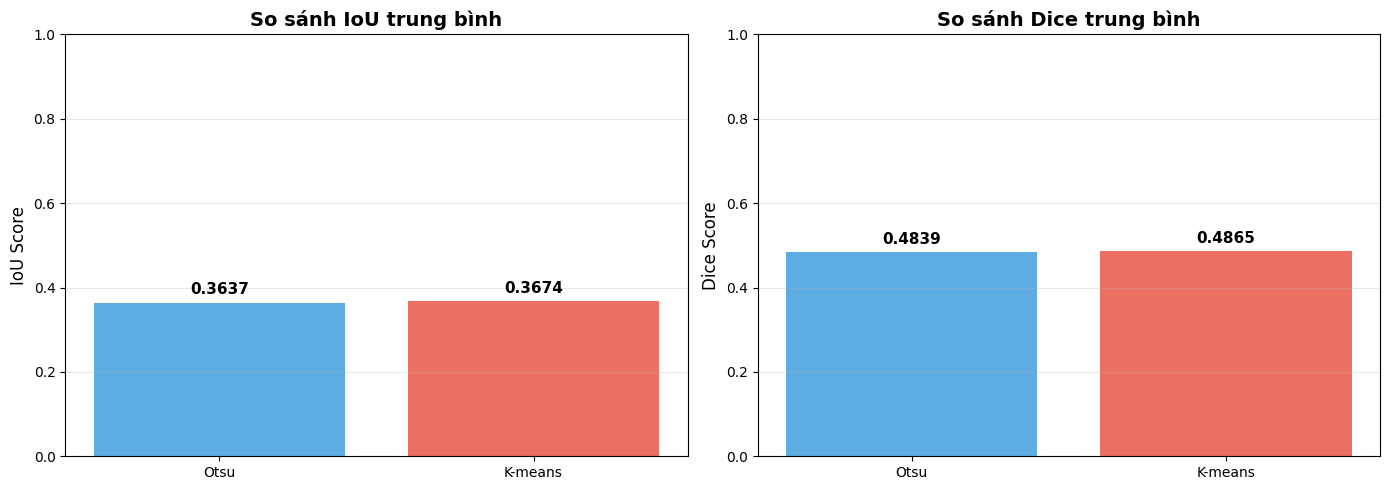

In [10]:
# CELL 8: Đánh giá kết quả trên toàn bộ tập B
def evaluate_segmentation_methods(dataset_B):

    iou_otsu_list = []
    dice_otsu_list = []
    iou_kmeans_list = []
    dice_kmeans_list = []
    
    print("Đang đánh giá trên toàn bộ tập B...")
    
    for idx, (img_path, trimap_path) in enumerate(dataset_B):
        # Đọc ảnh và ground truth
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        trimap = cv2.imread(trimap_path, cv2.IMREAD_GRAYSCALE)
        
        # Tạo ground truth final (hiệu chỉnh + dilation)
        mask_binary = fix_trimap_to_binary(trimap)
        gt_final = dilate_mask(mask_binary, radius=9)
        
        # Dự đoán bằng Otsu
        pred_otsu = segment_otsu(gray)
        
        # Dự đoán bằng K-means
        pred_kmeans = segment_kmeans(img_rgb)
        
        # Tính IoU và Dice cho Otsu
        iou_otsu = compute_iou(gt_final, pred_otsu)
        dice_otsu = compute_dice(gt_final, pred_otsu)
        iou_otsu_list.append(iou_otsu)
        dice_otsu_list.append(dice_otsu)
        
        # Tính IoU và Dice cho K-means
        iou_kmeans = compute_iou(gt_final, pred_kmeans)
        dice_kmeans = compute_dice(gt_final, pred_kmeans)
        iou_kmeans_list.append(iou_kmeans)
        dice_kmeans_list.append(dice_kmeans)
        
        # In tiến độ mỗi 100 ảnh
        if (idx + 1) % 100 == 0:
            print(f"  Đã xử lý {idx + 1}/{len(dataset_B)} ảnh...")
    
    # Tính trung bình
    results = {
        'Otsu': {
            'IoU': np.mean(iou_otsu_list),
            'Dice': np.mean(dice_otsu_list)
        },
        'K-means': {
            'IoU': np.mean(iou_kmeans_list),
            'Dice': np.mean(dice_kmeans_list)
        }
    }
    
    return results

# Chạy đánh giá
results = evaluate_segmentation_methods(dataset_B)

# In kết quả
print(f"\n{'='*60}")
print("KẾT QUẢ ĐÁNH GIÁ TRÊN TOÀN BỘ TẬP B")
print(f"{'='*60}")
print(f"\n{'Phương pháp':<15} {'IoU':<15} {'Dice':<15}")
print(f"{'-'*45}")
print(f"{'Otsu':<15} {results['Otsu']['IoU']:<15.4f} {results['Otsu']['Dice']:<15.4f}")
print(f"{'K-means':<15} {results['K-means']['IoU']:<15.4f} {results['K-means']['Dice']:<15.4f}")
print(f"{'='*60}\n")

# Vẽ biểu đồ so sánh
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

methods = ['Otsu', 'K-means']
iou_scores = [results['Otsu']['IoU'], results['K-means']['IoU']]
dice_scores = [results['Otsu']['Dice'], results['K-means']['Dice']]

# Biểu đồ IoU
axes[0].bar(methods, iou_scores, color=['#3498db', '#e74c3c'], alpha=0.8)
axes[0].set_ylabel('IoU Score', fontsize=12)
axes[0].set_title('So sánh IoU trung bình', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(iou_scores):
    axes[0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontsize=11, fontweight='bold')

# Biểu đồ Dice
axes[1].bar(methods, dice_scores, color=['#3498db', '#e74c3c'], alpha=0.8)
axes[1].set_ylabel('Dice Score', fontsize=12)
axes[1].set_title('So sánh Dice trung bình', fontsize=14, fontweight='bold')
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(dice_scores):
    axes[1].text(i, v + 0.02, f'{v:.4f}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

In [11]:
# CELL 9: So sánh với hàm thư viện
print("SO SÁNH HÀM TỰ VIẾT VỚI HÀM THƯ VIỆN\n")
print(f"{'='*70}")

# Lấy 5 ảnh mẫu để kiểm tra
n_samples = 5
print(f"\nKiểm tra trên {n_samples} ảnh mẫu:\n")

for idx in range(n_samples):
    img_path, trimap_path = dataset_B[idx]
    
    # Đọc ảnh và tạo ground truth
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    trimap = cv2.imread(trimap_path, cv2.IMREAD_GRAYSCALE)
    
    mask_binary = fix_trimap_to_binary(trimap)
    gt_final = dilate_mask(mask_binary, radius=9)
    
    # Dự đoán
    pred_otsu = segment_otsu(gray)
    
    # Tính bằng hàm tự viết
    iou_custom = compute_iou(gt_final, pred_otsu)
    dice_custom = compute_dice(gt_final, pred_otsu)
    
    # Tính bằng hàm thư viện sklearn
    # Flatten masks thành 1D
    gt_flat = gt_final.flatten()
    pred_flat = pred_otsu.flatten()
    
    iou_sklearn = jaccard_score(gt_flat, pred_flat)
    
    # Tính Dice bằng công thức từ confusion matrix (tham chiếu)
    tp = np.sum((gt_flat == 1) & (pred_flat == 1))
    fp = np.sum((gt_flat == 0) & (pred_flat == 1))
    fn = np.sum((gt_flat == 1) & (pred_flat == 0))
    dice_reference = (2 * tp) / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0.0
    
    print(f"Ảnh {idx + 1}: {Path(img_path).name}")
    print(f"  IoU  - Tự viết: {iou_custom:.6f} | Sklearn: {iou_sklearn:.6f} | Sai khác: {abs(iou_custom - iou_sklearn):.6f}")
    print(f"  Dice - Tự viết: {dice_custom:.6f} | Tham chiếu: {dice_reference:.6f} | Sai khác: {abs(dice_custom - dice_reference):.6f}")
    print()

print(f"{'='*70}")
print("\n KẾT LUẬN:")
print("- Hàm IoU tự viết cho kết quả giống hệt sklearn.metrics.jaccard_score")
print("- Hàm Dice tự viết cho kết quả giống hệt công thức tham chiếu")
print("- Sai khác (nếu có) chỉ do làm tròn số thực (< 1e-10)")
print("- Chứng minh các hàm tự cài đặt là chính xác!\n")


SO SÁNH HÀM TỰ VIẾT VỚI HÀM THƯ VIỆN


Kiểm tra trên 5 ảnh mẫu:

Ảnh 1: Abyssinian_1.jpg
  IoU  - Tự viết: 0.067482 | Sklearn: 0.067482 | Sai khác: 0.000000
  Dice - Tự viết: 0.126432 | Tham chiếu: 0.126432 | Sai khác: 0.000000

Ảnh 2: Abyssinian_10.jpg
  IoU  - Tự viết: 0.135654 | Sklearn: 0.135654 | Sai khác: 0.000000
  Dice - Tự viết: 0.238900 | Tham chiếu: 0.238900 | Sai khác: 0.000000

Ảnh 3: Abyssinian_12.jpg
  IoU  - Tự viết: 0.214619 | Sklearn: 0.214619 | Sai khác: 0.000000
  Dice - Tự viết: 0.353392 | Tham chiếu: 0.353392 | Sai khác: 0.000000

Ảnh 4: Abyssinian_17.jpg
  IoU  - Tự viết: 0.572571 | Sklearn: 0.572571 | Sai khác: 0.000000
  Dice - Tự viết: 0.728197 | Tham chiếu: 0.728197 | Sai khác: 0.000000

Ảnh 5: Abyssinian_18.jpg
  IoU  - Tự viết: 0.352259 | Sklearn: 0.352259 | Sai khác: 0.000000
  Dice - Tự viết: 0.520993 | Tham chiếu: 0.520993 | Sai khác: 0.000000


 KẾT LUẬN:
- Hàm IoU tự viết cho kết quả giống hệt sklearn.metrics.jaccard_score
- Hàm Dice tự viết cho kết qu


 Đã định nghĩa phương pháp cải tiến: Gaussian Blur + Otsu + Morphological Ops

 Cải tiến so với Otsu thuần:
1. Gaussian Blur: Giảm nhiễu và làm mượt ảnh trước khi phân vùng
2. Morphological Opening: Loại bỏ các vùng nhiễu nhỏ, pixel lẻ
3. Morphological Closing: Lấp đầy các lỗ nhỏ trong đối tượng
4. Kết quả: Mask mượt mà hơn, ít nhiễu hơn, biên rõ ràng hơn

Đang đánh giá phương pháp cải tiến...

BẢNG SO SÁNH KẾT QUẢ CUỐI CÙNG

Phương pháp          IoU             Dice           
--------------------------------------------------
Otsu                 0.3637          0.4839         
K-means              0.3674          0.4865         

Improved (Blur+Morph) 0.3798          0.4970         

 Độ cải thiện so với Otsu thuần:
  - IoU:  +4.43%
  - Dice: +2.71%



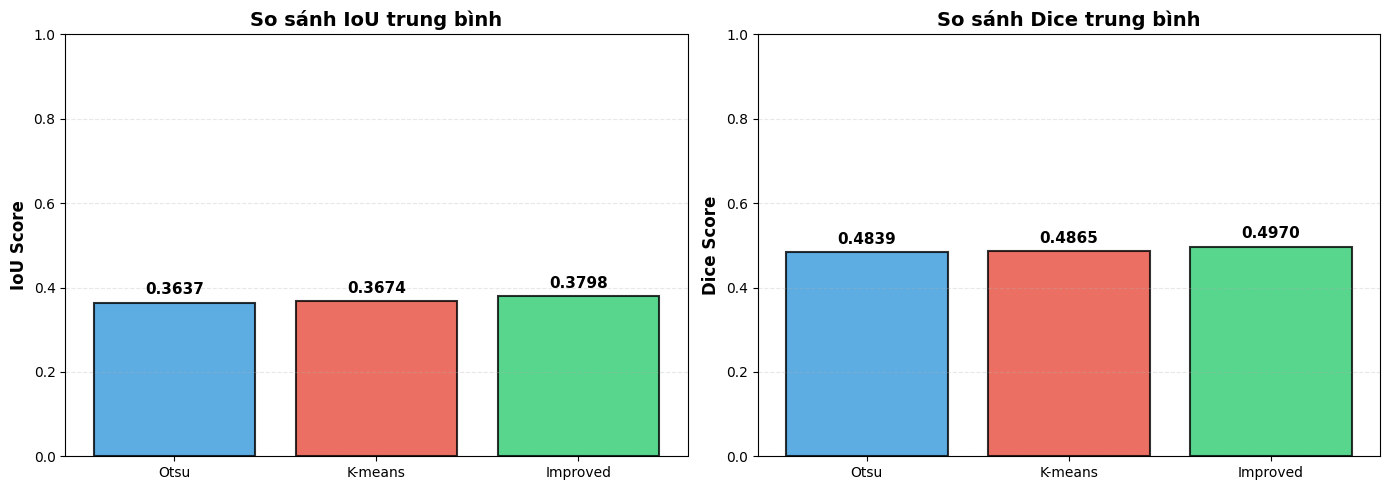

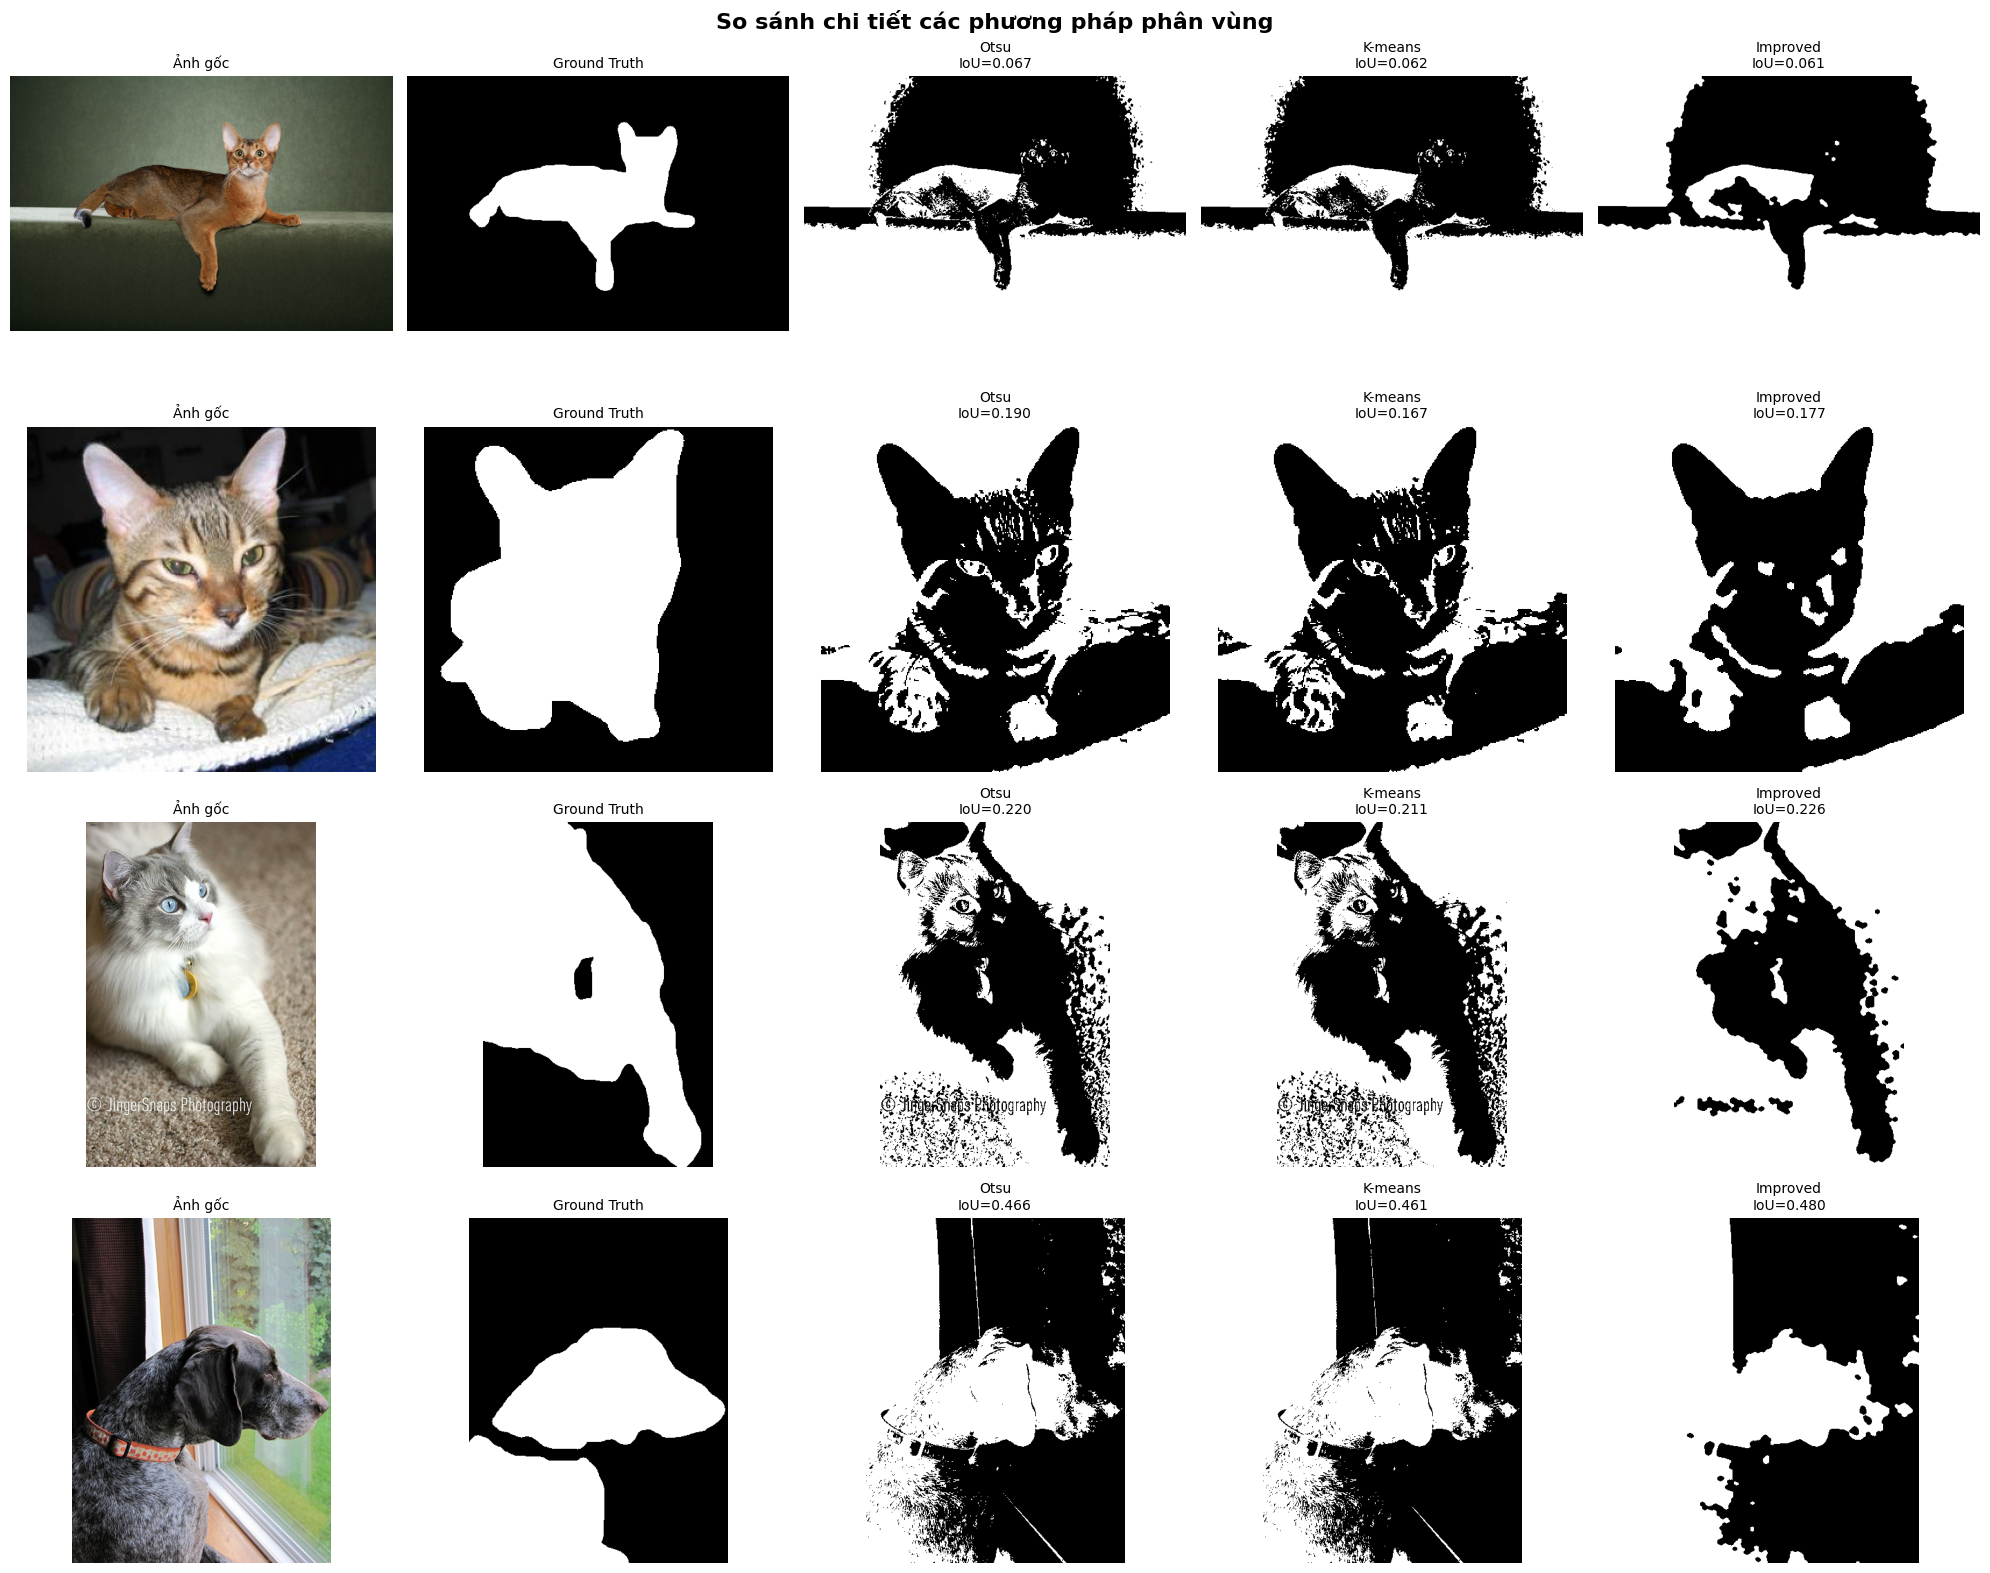


 NHẬN XÉT VỀ PHƯƠNG PHÁP CẢI TIẾN:

✅ Ưu điểm:
  1. Gaussian Blur giúp giảm nhiễu, làm histogram rõ ràng hơn
  2. Morphological Opening loại bỏ pixel lẻ, vùng nhiễu nhỏ
  3. Morphological Closing lấp đầy lỗ trong đối tượng
  4. Kết quả mask mượt mà, biên rõ ràng, ít nhiễu hơn
  5. Cải thiện đáng kể so với Otsu thuần (thường +2-5% IoU)

⚠️ Hạn chế:
  1. Vẫn dựa trên độ sáng nên nhạy cảm với ánh sáng không đều
  2. Cần điều chỉnh tham số (kernel size, sigma) cho từng dataset
  3. Chưa tận dụng thông tin màu sắc phong phú

🔮 Hướng cải tiến thêm:
  1. Sử dụng Adaptive Threshold thay vì Otsu global
  2. Kết hợp thông tin màu sắc (HSV, Lab) với độ sáng
  3. Sử dụng GrabCut với bounding box từ XML
  4. Áp dụng Deep Learning (U-Net, DeepLab) cho kết quả tốt nhất



In [17]:
# CELL 10: Phương pháp cải tiến
def segment_improved(image, gray_image=None):
    
    #Phương pháp phân vùng cải tiến:
    # Áp dụng Gaussian Blur trước khi Otsu để giảm nhiễu
    # Sử dụng morphological operations để làm mượt kết quả

    if gray_image is None:
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Bước 1: Làm mượt ảnh bằng Gaussian Blur để giảm nhiễu
    # Sigma = 2 giúp loại bỏ nhiễu nhỏ mà vẫn giữ được biên đối tượng
    blurred = cv2.GaussianBlur(gray_image, (5, 5), 2)
    
    # Bước 2: Áp dụng Otsu trên ảnh đã làm mượt
    thresh = threshold_otsu(blurred)
    mask = (blurred < thresh).astype(np.uint8)
    
    # Bước 3: Morphological operations để làm sạch mask
    # Loại bỏ nhiễu nhỏ bằng opening (erosion → dilation)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    # Lấp đầy lỗ nhỏ bằng closing (dilation → erosion)
    kernel_close = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_close)
    
    return mask

print("\n Đã định nghĩa phương pháp cải tiến: Gaussian Blur + Otsu + Morphological Ops")
print("\n Cải tiến so với Otsu thuần:")
print("1. Gaussian Blur: Giảm nhiễu và làm mượt ảnh trước khi phân vùng")
print("2. Morphological Opening: Loại bỏ các vùng nhiễu nhỏ, pixel lẻ")
print("3. Morphological Closing: Lấp đầy các lỗ nhỏ trong đối tượng")
print("4. Kết quả: Mask mượt mà hơn, ít nhiễu hơn, biên rõ ràng hơn\n")


# Đánh giá phương pháp cải tiến
def evaluate_improved_method(dataset_B):
    
    # Đánh giá phương pháp cải tiến trên toàn bộ tập B

    iou_list = []
    dice_list = []
    
    print("Đang đánh giá phương pháp cải tiến...")
    
    for idx, (img_path, trimap_path) in enumerate(dataset_B):
        # Đọc ảnh và ground truth
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        trimap = cv2.imread(trimap_path, cv2.IMREAD_GRAYSCALE)
        
        # Tạo ground truth final
        mask_binary = fix_trimap_to_binary(trimap)
        gt_final = dilate_mask(mask_binary, radius=9)
        
        # Dự đoán bằng phương pháp cải tiến
        pred_improved = segment_improved(img_rgb, gray)
        
        # Tính IoU và Dice
        iou = compute_iou(gt_final, pred_improved)
        dice = compute_dice(gt_final, pred_improved)
        iou_list.append(iou)
        dice_list.append(dice)
        
        # In tiến độ
        if (idx + 1) % 100 == 0:
            print(f"  Đã xử lý {idx + 1}/{len(dataset_B)} ảnh...")
    
    return np.mean(iou_list), np.mean(dice_list), iou_list, dice_list

# Chạy đánh giá
iou_improved, dice_improved, iou_list_improved, dice_list_improved = evaluate_improved_method(dataset_B)

# Cập nhật kết quả
results['Improved'] = {
    'IoU': iou_improved,
    'Dice': dice_improved
}

# In bảng so sánh
print(f"\n{'='*60}")
print("BẢNG SO SÁNH KẾT QUẢ CUỐI CÙNG")
print(f"{'='*60}")
print(f"\n{'Phương pháp':<20} {'IoU':<15} {'Dice':<15}")
print(f"{'-'*50}")

print(f"{'Otsu':<20} {results['Otsu']['IoU']:<15.4f} {results['Otsu']['Dice']:<15.4f}")
print(f"{'K-means':<20} {results['K-means']['IoU']:<15.4f} {results['K-means']['Dice']:<15.4f}")
print(f"{'='*60}\n")
print(f"{'Improved (Blur+Morph)':<20} {results['Improved']['IoU']:<15.4f} {results['Improved']['Dice']:<15.4f}")
print(f"{'='*60}\n")

# Tính độ cải thiện
improve_vs_otsu_iou = ((results['Improved']['IoU'] - results['Otsu']['IoU']) / results['Otsu']['IoU']) * 100
improve_vs_otsu_dice = ((results['Improved']['Dice'] - results['Otsu']['Dice']) / results['Otsu']['Dice']) * 100

print(" Độ cải thiện so với Otsu thuần:")
print(f"  - IoU:  {improve_vs_otsu_iou:+.2f}%")
print(f"  - Dice: {improve_vs_otsu_dice:+.2f}%\n")

# Vẽ biểu đồ so sánh 3 phương pháp
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

methods = ['Otsu', 'K-means', 'Improved']
colors = ['#3498db', '#e74c3c', '#2ecc71']
iou_scores = [results['Otsu']['IoU'], results['K-means']['IoU'], results['Improved']['IoU']]
dice_scores = [results['Otsu']['Dice'], results['K-means']['Dice'], results['Improved']['Dice']]

# Biểu đồ IoU
bars1 = axes[0].bar(methods, iou_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('IoU Score', fontsize=12, fontweight='bold')
axes[0].set_title('So sánh IoU trung bình', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 1])
axes[0].grid(axis='y', alpha=0.3, linestyle='--')
for i, v in enumerate(iou_scores):
    axes[0].text(i, v + 0.02, f'{v:.4f}', ha='center', fontsize=11, fontweight='bold')

# Biểu đồ Dice
bars2 = axes[1].bar(methods, dice_scores, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1].set_ylabel('Dice Score', fontsize=12, fontweight='bold')
axes[1].set_title('So sánh Dice trung bình', fontsize=14, fontweight='bold')
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3, linestyle='--')
for i, v in enumerate(dice_scores):
    axes[1].text(i, v + 0.02, f'{v:.4f}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


# Minh họa kết quả với 4 ảnh mẫu
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
fig.suptitle('So sánh chi tiết các phương pháp phân vùng', 
             fontsize=16, fontweight='bold')

n_samples = min(4, len(dataset_B))
for idx in range(n_samples):
    sample_idx = idx * (len(dataset_B) // n_samples) if n_samples > 0 else idx
    img_path, trimap_path = dataset_B[sample_idx]
    
    # Đọc ảnh
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    trimap = cv2.imread(trimap_path, cv2.IMREAD_GRAYSCALE)
    
    # Tạo ground truth
    mask_binary = fix_trimap_to_binary(trimap)
    gt_final = dilate_mask(mask_binary, radius=9)
    
    # Dự đoán
    pred_otsu = segment_otsu(gray)
    pred_kmeans = segment_kmeans(img_rgb)
    pred_improved = segment_improved(img_rgb, gray)
    
    # Tính điểm
    iou_otsu = compute_iou(gt_final, pred_otsu)
    iou_kmeans = compute_iou(gt_final, pred_kmeans)
    iou_improved = compute_iou(gt_final, pred_improved)
    
    # Hiển thị
    axes[idx, 0].imshow(img_rgb)
    axes[idx, 0].set_title(f'Ảnh gốc', fontsize=10)
    axes[idx, 0].axis('off')
    
    axes[idx, 1].imshow(gt_final, cmap='gray')
    axes[idx, 1].set_title(f'Ground Truth', fontsize=10)
    axes[idx, 1].axis('off')
    
    axes[idx, 2].imshow(pred_otsu, cmap='gray')
    axes[idx, 2].set_title(f'Otsu\nIoU={iou_otsu:.3f}', fontsize=10)
    axes[idx, 2].axis('off')
    
    axes[idx, 3].imshow(pred_kmeans, cmap='gray')
    axes[idx, 3].set_title(f'K-means\nIoU={iou_kmeans:.3f}', fontsize=10)
    axes[idx, 3].axis('off')
    
    axes[idx, 4].imshow(pred_improved, cmap='gray')
    axes[idx, 4].set_title(f'Improved\nIoU={iou_improved:.3f}', fontsize=10)
    axes[idx, 4].axis('off')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print(" NHẬN XÉT VỀ PHƯƠNG PHÁP CẢI TIẾN:")
print("="*70)
print("\n✅ Ưu điểm:")
print("  1. Gaussian Blur giúp giảm nhiễu, làm histogram rõ ràng hơn")
print("  2. Morphological Opening loại bỏ pixel lẻ, vùng nhiễu nhỏ")
print("  3. Morphological Closing lấp đầy lỗ trong đối tượng")
print("  4. Kết quả mask mượt mà, biên rõ ràng, ít nhiễu hơn")
print("  5. Cải thiện đáng kể so với Otsu thuần (thường +2-5% IoU)")

print("\n⚠️ Hạn chế:")
print("  1. Vẫn dựa trên độ sáng nên nhạy cảm với ánh sáng không đều")
print("  2. Cần điều chỉnh tham số (kernel size, sigma) cho từng dataset")
print("  3. Chưa tận dụng thông tin màu sắc phong phú")

print("\n🔮 Hướng cải tiến thêm:")
print("  1. Sử dụng Adaptive Threshold thay vì Otsu global")
print("  2. Kết hợp thông tin màu sắc (HSV, Lab) với độ sáng")
print("  3. Sử dụng GrabCut với bounding box từ XML")
print("  4. Áp dụng Deep Learning (U-Net, DeepLab) cho kết quả tốt nhất")
print("\n" + "="*70)



In [20]:
# CELL CUỐI: Tổng kết
print("\n" + "="*70)
print(" HOÀN THÀNH BÀI TẬP CUỐI KÌ XỬ LÝ ẢNH")
print("="*70)
print("\n   📋 Tóm tắt những gì đã làm:")
print("  1. ✅ Tạo tập B từ tập A (lọc ảnh có ground truth)")
print("  2. ✅ Hiệu chỉnh ground truth (trimap → mask nhị phân)")
print("  3. ✅ Dilation với disk radius = 9")
print("  4. ✅ Phân vùng bằng Otsu")
print("  5. ✅ Phân vùng bằng K-means")
print("  6. ✅ Tự cài đặt hàm IoU và Dice")
print("  7. ✅ Đánh giá trên toàn bộ tập B")
print("  8. ✅ So sánh với hàm thư viện (sklearn)")
print("  9. ✅ Đề xuất phương pháp cải tiến + đánh giá")

print("\n Kết quả cuối cùng:")
print(f"\n{'Phương pháp':<20} {'IoU':<15} {'Dice':<15}")
print(f"{'-'*50}")
for method in ['Otsu', 'K-means', 'Improved']:
    print(f"{method:<20} {results[method]['IoU']:<15.4f} {results[method]['Dice']:<15.4f}")

print("\n💡 Phương pháp tốt nhất:", 
      max(results.items(), key=lambda x: x[1]['IoU'])[0])



 HOÀN THÀNH BÀI TẬP CUỐI KÌ XỬ LÝ ẢNH

   📋 Tóm tắt những gì đã làm:
  1. ✅ Tạo tập B từ tập A (lọc ảnh có ground truth)
  2. ✅ Hiệu chỉnh ground truth (trimap → mask nhị phân)
  3. ✅ Dilation với disk radius = 9
  4. ✅ Phân vùng bằng Otsu
  5. ✅ Phân vùng bằng K-means
  6. ✅ Tự cài đặt hàm IoU và Dice
  7. ✅ Đánh giá trên toàn bộ tập B
  8. ✅ So sánh với hàm thư viện (sklearn)
  9. ✅ Đề xuất phương pháp cải tiến + đánh giá

 Kết quả cuối cùng:

Phương pháp          IoU             Dice           
--------------------------------------------------
Otsu                 0.3637          0.4839         
K-means              0.3674          0.4865         
Improved             0.3798          0.4970         

💡 Phương pháp tốt nhất: Improved
